In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, string
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('Preprocessed Fake Reviews Detection Dataset.csv')
df.head()

,Unnamed: 0,category,rating,label,text_
0,0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort love itveri pretti
1,1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin ive mine coupl year
2,2,Home_and_Kitchen_5,5.0,CG,pillow save back love look feel pillow
3,3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price
4,4,Home_and_Kitchen_5,5.0,CG,nice set good qualiti set two month


In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort love itveri pretti
1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin ive mine coupl year
2,Home_and_Kitchen_5,5.0,CG,pillow save back love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price
4,Home_and_Kitchen_5,5.0,CG,nice set good qualiti set two month


In [5]:
df.dropna(inplace=True)

In [6]:
df['length'] = df['text_'].apply(len)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40431 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40431 non-null  object 
 1   rating    40431 non-null  float64
 2   label     40431 non-null  object 
 3   text_     40431 non-null  object 
 4   length    40431 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


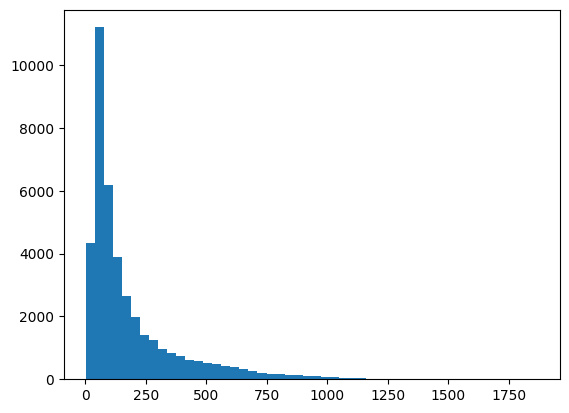

In [8]:
plt.hist(df['length'],bins=50)
plt.show()

In [9]:
df.groupby('label').describe()

rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
CG     20215.0  4.259906  1.141092  1.0  4.0  5.0  5.0  5.0  20215.0   
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0  20216.0   

                                                                
             mean         std  min   25%    50%    75%     max  
label                                                           
CG     154.120406  155.257964  4.0  51.0   88.0  192.0  1191.0  
OR     219.240503  233.462136  8.0  68.0  123.0  272.0  1868.0

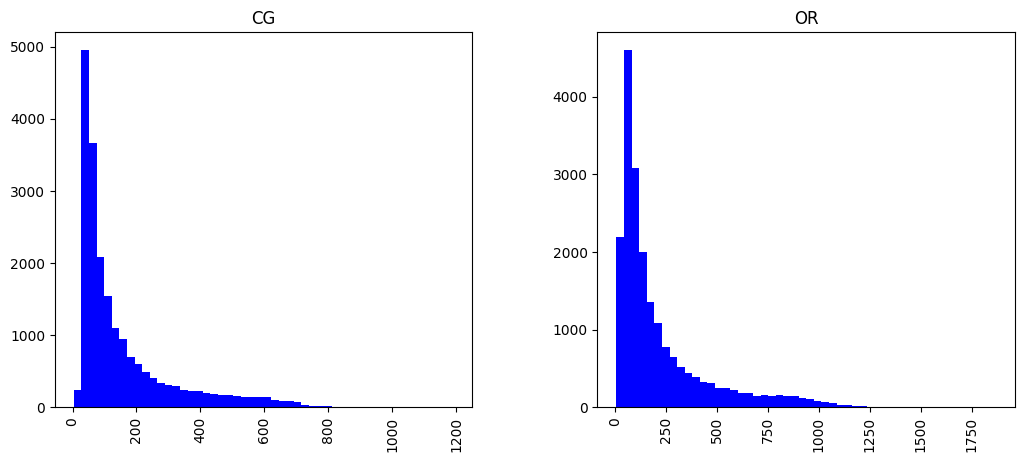

In [10]:
df.hist(column='length',by='label',bins=50,color='blue',figsize=(12,5))
plt.show()

Let's extract the largest review...

In [11]:
df[df['label']=='OR'][['text_','length']].sort_values(by='length',ascending=False).head().iloc[0].text_

'weak current scienc see twice agre much posit five star review respect read review ill repeat everyth like present found goofi over ear hairdo facial hair arrang daniel vitali describ wild food expert distract ugh ditto david wolf extrem goofi wild hairdo hand jon gabriel describ author weight loss expert nice groom good present stori person transform fellow pound whew becom jock normal weight inspir christian northrup preserv rank one america cutest doctor realli nice look woman present dr mercola jason vale kri carr alejandro junger fine disappoint jami oliv popular uk give babi cow growth fluid pas unscientif popular idea milk none present anyth zilch say work doctor colin campbel milk bodi bad good see present take stand sugar agre evil sugar refin carbohydr respect dr northrup fat make fat sugar statement pas muster commun expert recogn evil sugar mutual exclus recogn proven danger fat particularli fat dead anim extract fat kind oliv oil health food datahookproductlinklink classa

In [12]:
df.length.describe()

count    40431.000000
mean       186.681259
std        200.908907
min          4.000000
25%         57.000000
50%        105.000000
75%        229.000000
max       1868.000000
Name: length, dtype: float64

In [13]:
def text_process(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [14]:
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x000001EFABC1C900>)

In [15]:
bow_transformer.fit(df['text_'])
print("Total Vocabulary:",len(bow_transformer.vocabulary_))

Total Vocabulary: 36407


In [16]:
review4 = df['text_'][3]
review4

'miss inform use great product price'

In [17]:
bow_msg4 = bow_transformer.transform([review4])
print(bow_msg4)
print(bow_msg4.shape)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (1, 36407)>
  Coords	Values
  (0, 13888)	1
  (0, 16457)	1
  (0, 20740)	1
  (0, 25033)	1
  (0, 25180)	1
  (0, 33967)	1
(1, 36407)


There are 6 unique words in the 4th review.

In [18]:
print(bow_transformer.get_feature_names_out()[15841])
print(bow_transformer.get_feature_names_out()[23848])

hum
pena


In [19]:
bow_reviews = bow_transformer.transform(df['text_'])

In [20]:
print("Shape of Bag of Words Transformer for the entire reviews corpus:",bow_reviews.shape)
print("Amount of non zero values in the bag of words model:",bow_reviews.nnz)

Shape of Bag of Words Transformer for the entire reviews corpus: (40431, 36407)
Amount of non zero values in the bag of words model: 1007384


In [21]:
print("Sparsity:",np.round((bow_reviews.nnz/(bow_reviews.shape[0]*bow_reviews.shape[1]))*100,2))

Sparsity: 0.07


In [22]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_rev4 = tfidf_transformer.transform(bow_msg4)
print(bow_msg4)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (1, 36407)>
  Coords	Values
  (0, 13888)	1
  (0, 16457)	1
  (0, 20740)	1
  (0, 25033)	1
  (0, 25180)	1
  (0, 33967)	1


In [23]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['mango']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['book']])

10.91422964906803
2.8236741309927584


In [24]:
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape:",tfidf_reviews.shape)
print("No. of Dimensions:",tfidf_reviews.ndim)

Shape: (40431, 36407)
No. of Dimensions: 2


## Creating training and testing data

In [25]:
review_train, review_test, label_train, label_test = train_test_split(df['text_'],df['label'],test_size=0.35)

In [26]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [27]:
#Support Vector Machines Prediction
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',SVC())
])

In [28]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001EFABC1C900>)),
                ('tfidf', TfidfTransformer()), ('classifier', SVC())])

In [29]:
svc_pred = pipeline.predict(review_test)
svc_pred

array(['CG', 'OR', 'CG', ..., 'OR', 'CG', 'OR'], dtype=object)

In [30]:
print('Classification Report:',classification_report(label_test,svc_pred))
print('Confusion Matrix:',confusion_matrix(label_test,svc_pred))
print('Accuracy Score:',accuracy_score(label_test,svc_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.89      0.86      0.88      7088
          OR       0.87      0.90      0.88      7063

    accuracy                           0.88     14151
   macro avg       0.88      0.88      0.88     14151
weighted avg       0.88      0.88      0.88     14151

Confusion Matrix: [[6115  973]
 [ 728 6335]]
Accuracy Score: 0.8797964808140768
Model Prediction Accuracy: 87.98%


# Pickle File Generation

In [31]:
# Save the model to a file
with open('Fake_Review_Detector.pkl', 'wb') as f:
    pickle.dump(pipeline, f)